# Check & prepare the prerequisites

Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Check how many images in images folder

In [2]:
image_data_dir = "./images"
image_data_dir = pathlib.Path(image_data_dir)
image_count = len(list(image_data_dir.glob('*/*.png')))
image_count_thumb = len(list(image_data_dir.glob('thumb/*.png')))
image_count_ok = len(list(image_data_dir.glob('ok/*.png')))
print("Total = "+str(image_count))
print("Thumb = "+str(image_count_thumb))
print("OK = "+str(image_count_ok))

Total = 400
Thumb = 200
OK = 200


Show thumb image

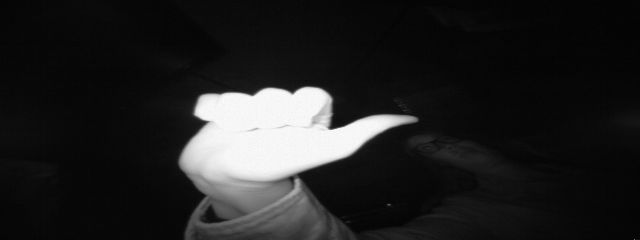

In [3]:
thumb = list(image_data_dir.glob('thumb/*'))
PIL.Image.open(str(thumb[0]))

Show ok image

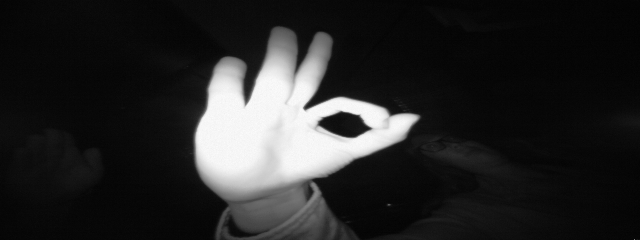

In [4]:
ok = list(image_data_dir.glob('ok/*'))
PIL.Image.open(str(ok[0]))

# Prepare dataset for model training

Define some parameters for the loader:

In [5]:
batch_size = 10
img_height = 180
img_width = 180

Let's use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 320 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 400 files belonging to 2 classes.
Using 80 files for validation.


There are class names in the class_names attribute on these datasets.
These correspond to the directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['ok', 'thumb']


# Visualize the dataset

Model Training is using these datasets by passing them to model.fit in a moment.

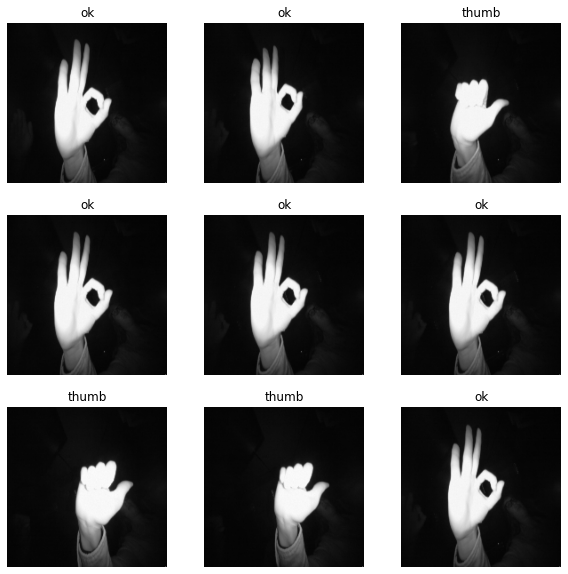

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 180, 180, 3)
(10,)


# Configure the dataset for performance

* Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make your input values small. Here, we will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.010421092 0.9808277


# Create the model

In [14]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model summary

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

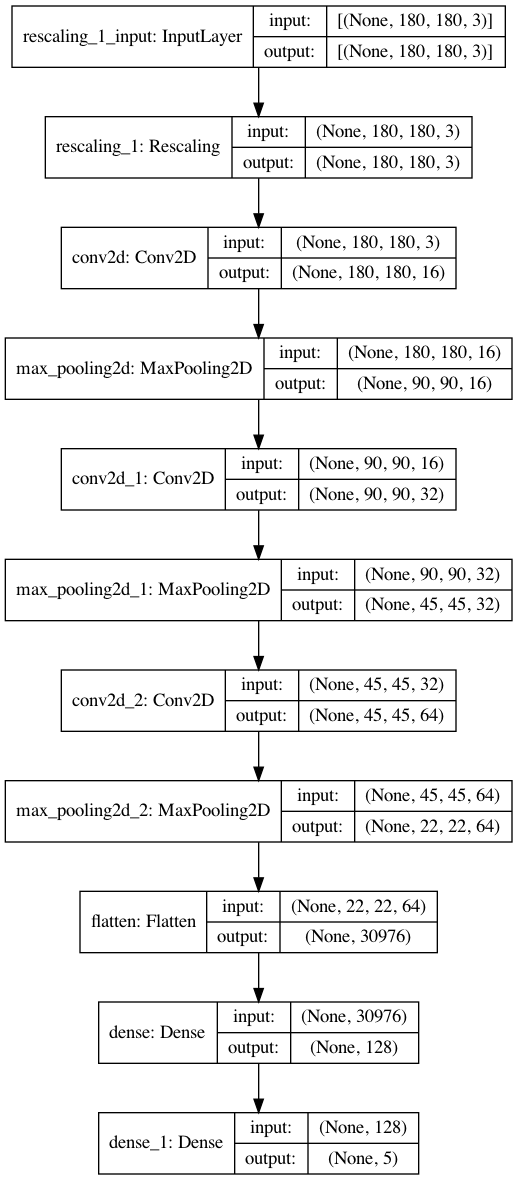

In [17]:
keras.utils.plot_model(model, "model_v1.png", show_shapes=True)

# Train the model

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
32/32 [==============================] - 9s 262ms/step - loss: 0.4862 - accuracy: 0.7288 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
32/32 [==============================] - 7s 232ms/step - loss: 3.4546e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
32/32 [==============================] - 7s 231ms/step - loss: 6.2361e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
32/32 [==============================] - 7s 219ms/step - loss: 2.1578e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
32/32 [==============================] - 8s 262ms/step - loss: 2.2308e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
32/32 [==============================] - 9s 280ms/step - loss: 1.3606e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
32/32 [==============================] - 10s 311ms/step - loss: 1.7112e-08 - accuracy: 1.0000

# Visual the result

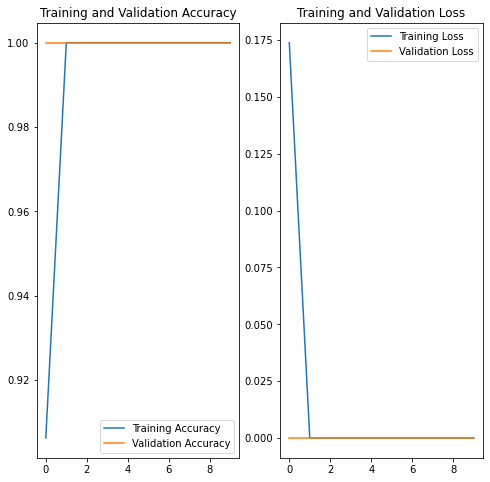

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Visualize few augmented examples look like by applying data augmentation to the same image several times.

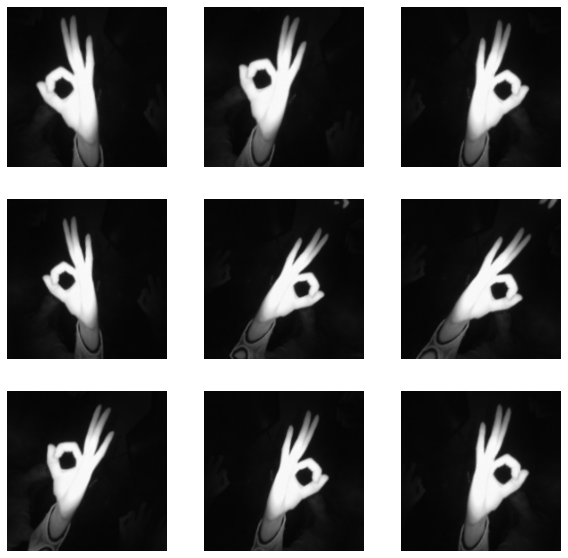

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout and retrain

Apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer. Create a new neural network using layers.Dropout, then train it using augmented images.

In [22]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile and train the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

Retrain the model

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
32/32 [==============================] - 10s 271ms/step - loss: 0.6784 - accuracy: 0.6931 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/15
32/32 [==============================] - 9s 266ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 4.2875e-04 - val_accuracy: 1.0000
Epoch 3/15
32/32 [==============================] - 9s 291ms/step - loss: 0.0762 - accuracy: 0.9866 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/15
32/32 [==============================] - 10s 312ms/step - loss: 0.1021 - accuracy: 0.9738 - val_loss: 2.4318e-04 - val_accuracy: 1.0000
Epoch 5/15
32/32 [==============================] - 8s 263ms/step - loss: 0.0058 - accuracy: 0.9992 - val_loss: 1.1746e-04 - val_accuracy: 1.0000
Epoch 6/15
32/32 [==============================] - 8s 255ms/step - loss: 0.0125 - accuracy: 0.9996 - val_loss: 5.9837e-05 - val_accuracy: 1.0000
Epoch 7/15
32/32 [==============================] - 8s 262ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 5.9307e-07 - val_a

# Visual the results after retrain

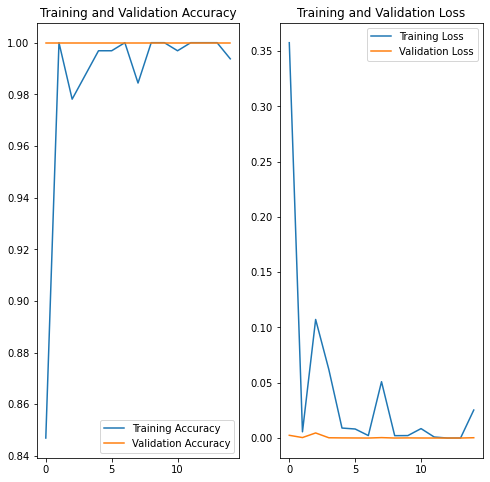

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
model.save('models/basic_neural')

INFO:tensorflow:Assets written to: models/basic_neural/assets


# Predict on new data

In [100]:
test_file_path = "./test_images"
test_file_path = pathlib.Path(test_file_path)
thumb_test_file_path = "./test_images/thumb/frame_01_05_0005.png"

img = keras.preprocessing.image.load_img(
    thumb_test_file_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to thumb with a 97.43 percent confidence.


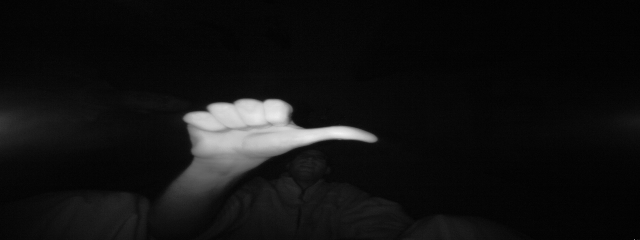

In [101]:
thumb_test = list(test_file_path.glob('thumb/*'))
PIL.Image.open(str(thumb_test[0]))

In [102]:
test_file_path = "./test_images"
test_file_path = pathlib.Path(test_file_path)
thumb_test_file_path = "./test_images/ok/frame_06_07_0009.png"

img = keras.preprocessing.image.load_img(
    thumb_test_file_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to ok with a 99.99 percent confidence.


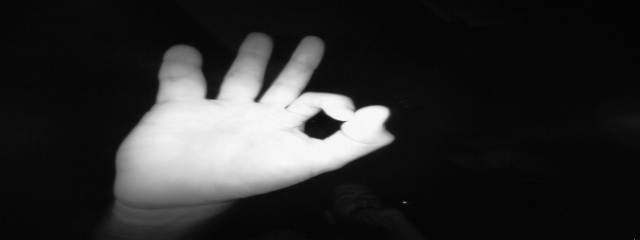

In [103]:
ok_test = list(test_file_path.glob('ok/*'))
PIL.Image.open(str(ok_test[0]))